In [1]:
!pip3 install pyensembl
!pyensembl install --release 99 --species mus_musculus


  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
^C
Operation cancelled by user
2020-05-19 12:08:08,460 - pyensembl.shell - INFO - Running 'install' for EnsemblRelease(release=99, species='mus_musculus')
2020-05-19 12:08:08,839 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /home/siddarth/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.cdna.all.fa.gz.pickle
2020-05-19 12:08:08,887 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /home/siddarth/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.ncrna.fa.gz.pickle
2020-05-19 12:08:08,981 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /home/siddarth/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.pep.all.fa.gz.pickle


In [274]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pyensembl import EnsemblRelease

In [275]:
#from google.colab import drive
#drive.mount('/content/drive')

In [360]:
# dataFilePath = "/content/drive/My Drive/ScRNA_data/GSE109262_ESC_RNA_counts.txt"
dataFilePath = "../data/GSE109262_ESC_RNA_counts.txt"

In [361]:
df = pd.read_csv(dataFilePath,sep='\t')

In [362]:
df.head(20)

,ESC_ens_id,ESC_A01,ESC_A02,ESC_A03,ESC_A04,ESC_A05,ESC_A06,ESC_A07,ESC_A08,ESC_A09,...,ESC_H01,ESC_H02,ESC_H03,ESC_H04,ESC_H05,ESC_H06,ESC_H07,ESC_H08,ESC_H09,ESC_H10
0,ENSMUSG00000051951,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000025900,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000025902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000033845,0,653,246,297,464,277,548,346,838,...,0,130,703,407,1069,1081,240,494,619,368
4,ENSMUSG00000025903,0,481,261,181,118,320,352,280,560,...,0,113,255,171,767,125,213,157,690,132
5,ENSMUSG00000104217,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ENSMUSG00000033813,0,513,670,269,180,103,171,233,72,...,0,108,244,310,505,921,74,605,324,84
7,ENSMUSG00000002459,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ENSMUSG00000033793,0,405,941,190,148,157,231,326,141,...,0,110,139,0,654,1350,60,452,813,198
9,ENSMUSG00000025905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [363]:
df_ids = df['ESC_ens_id']

In [364]:
df_ids.head(20)

0     ENSMUSG00000051951
1     ENSMUSG00000025900
2     ENSMUSG00000025902
3     ENSMUSG00000033845
4     ENSMUSG00000025903
5     ENSMUSG00000104217
6     ENSMUSG00000033813
7     ENSMUSG00000002459
8     ENSMUSG00000033793
9     ENSMUSG00000025905
10    ENSMUSG00000033774
11    ENSMUSG00000025907
12    ENSMUSG00000087247
13    ENSMUSG00000033740
14    ENSMUSG00000051285
15    ENSMUSG00000025909
16    ENSMUSG00000061024
17    ENSMUSG00000025911
18    ENSMUSG00000067879
19    ENSMUSG00000025912
Name: ESC_ens_id, dtype: object

In [365]:
ensembl = EnsemblRelease(species="mouse")

In [366]:
def rpkm(counts, lengths):
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return(normed)


In [367]:
gene = ensembl.gene_by_id('ENSMUSG00000025900')

In [368]:
tr_lengths = []
for i in df_ids:
  try:
    gene = ensembl.gene_by_id(i)
    start = gene.start
    end = gene.end
  except ValueError:
    start = 0
    end = 10000
  tr_lengths.append(end-start)

In [369]:
tr_lengths = np.asarray(tr_lengths)

In [370]:
df = df.drop('ESC_ens_id',axis=1)
data = df.to_numpy()

In [371]:
norm_data = rpkm(data,tr_lengths)

In [372]:
norm_data.shape

(22084, 80)

# Filtering out cells and Genes

In [373]:
from sklearn.feature_selection import VarianceThreshold

## Cells

In [ ]:
rem_cells = VarianceThreshold(threshold=(5000))
norm_data = rem_cells.fit_transform(norm_data)
norm_data.shape

## Genes

In [374]:
norm_data = norm_data.T

In [375]:
select = VarianceThreshold(threshold=(250000))
norm_data = select.fit_transform(norm_data)

In [376]:
norm_data.shape

(80, 25)

In [377]:
norm_data

array([[   0.        ,    0.        , 6601.59256819, ...,    0.        ,
           0.        ,    0.        ],
       [  19.85616615,   93.24527651,   13.97578371, ..., 1190.35761577,
         143.85498497, 2475.40108205],
       [  24.4318962 ,   43.89099112,   57.93295363, ...,  115.6393098 ,
          24.44264285,   36.00104045],
       ...,
       [  36.3820489 ,   55.12159375,   18.22006938, ..., 1528.19970536,
         221.93977215, 1049.46492167],
       [  22.93320932,   52.43800181,   35.02142866, ..., 1219.95899107,
         183.51769491, 1604.34026026],
       [  49.99596788,   43.36032756,   45.7055923 , ..., 1160.0190096 ,
         135.07400911,  962.07490844]])

In [378]:
model = KMeans(n_clusters=4)

In [379]:
model.fit(norm_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [380]:
labels = model.predict(norm_data)

In [381]:
print(labels)

[9 5 0 5 5 0 0 5 0 7 8 8 6 6 7 5 5 5 0 7 5 5 5 0 0 5 6 0 0 5 8 2 8 0 5 5 0
 0 5 0 6 0 0 0 0 8 0 0 0 5 1 8 5 0 0 5 5 0 5 5 5 0 8 4 5 6 5 6 0 6 3 5 0 5
 0 5 7 5 0 0]


In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
plot_data = pca.fit_transform(norm_data)

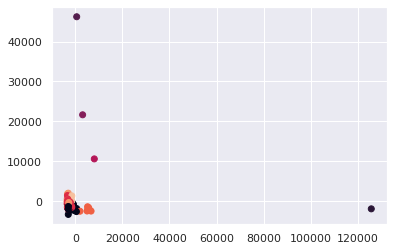

In [383]:
plt.scatter(plot_data[:,0],plot_data[:,1],c = labels)

# Genes with Highest Variance

In [ ]:
indices = select.get_support(indices=True)
genes = []
for i in indices:
  genes.append(df_ids[i])

# TSNE

In [384]:
from sklearn.manifold import TSNE

In [385]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(norm_data)

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 1394.771666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.399994
[t-SNE] KL divergence after 300 iterations: 0.801623


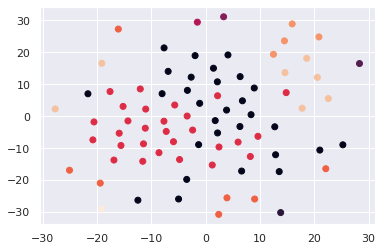

In [386]:
plt.scatter(tsne_results[:,0],tsne_results[:,1],c = labels)

In [387]:
name_cells_unformatted = df.T.columns.values
name_cells_unformatted

array([    0,     1,     2, ..., 22081, 22082, 22083])

In [388]:
name_cells = name_cells_unformatted[1:]
name_cells

array([    1,     2,     3, ..., 22081, 22082, 22083])

In [389]:
labelled_cluster = dict(zip(name_cells, labels))

# The Final Clusters

In [390]:
i = 0
for i in range(4):
    print("Cluster " + str(i) + ":")
    for cell, cluster in labelled_cluster.items():
        if cluster == i:
            print(cell)
    i += 1

Cluster 0:
3
6
7
9
19
24
25
28
29
34
37
38
40
42
43
44
45
47
48
49
54
55
58
62
69
73
75
79
80
Cluster 1:
51
Cluster 2:
32
Cluster 3:
71
Cluster 4:
64
Cluster 5:
2
4
5
8
16
17
18
21
22
23
26
30
35
36
39
50
53
56
57
59
60
61
65
67
72
74
76
78
Cluster 6:
13
14
27
41
66
68
70
Cluster 7:
10
15
20
77
Cluster 8:
11
12
31
33
46
52
63
Cluster 9:
1
